# Imports

In [1]:
import pandas as pd
import numpy as np
import os 
import xml.etree.ElementTree as ET
from lxml import objectify
import collections

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras import layers
from keras import models
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

from glob import glob

import cv2
import matplotlib.pylab as plt



# To Avoid errors


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'   #this one solves a dead kernel problem

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') #finds one GPU and one CPU
physical_devices[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [4]:
#avoiding out of memory (OOM) errors
tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Data preparation

In [5]:
mydf = pd.read_csv('dataset.csv', sep = '\t')

In [6]:
mydf

,filename,directory,xmin,ymin,xmax,ymax,width,height,defect,defect_ID
0,img_01_3402617700_00001.jpg,images/images\crescent_gap\img_01_3402617700_0...,1738,806,1948,993,2048,1000,crescent_gap,1
1,img_01_3402617700_01009.jpg,images/images\crescent_gap\img_01_3402617700_0...,1756,298,1967,858,2048,1000,crescent_gap,1
2,img_01_3436789500_00004.jpg,images/images\crease\img_01_3436789500_00004.jpg,981,182,2046,249,2048,1000,crease,0
3,img_01_3436814600_00259.jpg,images/images\silk_spot\img_01_3436814600_0025...,746,17,1011,993,2048,1000,silk_spot,6
4,img_01_3436815300_00473.jpg,images/images\silk_spot\img_01_3436815300_0047...,814,17,1522,978,2048,1000,silk_spot,6
...,...,...,...,...,...,...,...,...,...,...
2275,img_08_4406743300_00483.jpg,images/images\silk_spot\img_08_4406743300_0048...,690,260,840,675,2048,1000,silk_spot,6
2276,img_08_4406743300_00486.jpg,images/images\silk_spot\img_08_4406743300_0048...,959,484,1017,889,2048,1000,silk_spot,6
2277,img_08_4406743300_00698.jpg,images/images\silk_spot\img_08_4406743300_0069...,579,348,831,684,2048,1000,silk_spot,6
2278,img_08_4406743300_00699.jpg,images/images\silk_spot\img_08_4406743300_0069...,571,571,853,843,2048,1000,silk_spot,6


In [7]:
data_dir = mydf['directory'].values.tolist()
data_dir

['images/images\\crescent_gap\\img_01_3402617700_00001.jpg',
 'images/images\\crescent_gap\\img_01_3402617700_01009.jpg',
 'images/images\\crease\\img_01_3436789500_00004.jpg',
 'images/images\\silk_spot\\img_01_3436814600_00259.jpg',
 'images/images\\silk_spot\\img_01_3436815300_00473.jpg',
 'images/images\\silk_spot\\img_01_3436815300_00477.jpg',
 'images/images\\silk_spot\\img_01_3436815300_00478.jpg',
 'images/images\\silk_spot\\img_01_3437011300_00918.jpg',
 'images/images\\crescent_gap\\img_01_424799300_01133.jpg',
 'images/images\\crescent_gap\\img_01_424799600_00001.jpg',
 'images/images\\crescent_gap\\img_01_424799600_00002.jpg',
 'images/images\\crescent_gap\\img_01_424825700_00001.jpg',
 'images/images\\crescent_gap\\img_01_424826100_00001.jpg',
 'images/images\\crescent_gap\\img_01_424826300_00950.jpg',
 'images/images\\crescent_gap\\img_01_424826800_00002.jpg',
 'images/images\\crescent_gap\\img_01_424826800_00003.jpg',
 'images/images\\water_spot\\img_01_424995500_00255.j

In [8]:
def resize(directory):
    image = cv2.imread(directory)
    resized_image = cv2.resize(image, (224,224))
    resized_image = resized_image /255.0
    return resized_image


In [9]:
image = cv2.imread('images/images\\crescent_gap\\img_01_3402617700_00001.jpg')
image.shape

(1000, 2048, 3)

In [10]:
x = []
for i in data_dir:
    x.append(resize(i))    
x = np.array(x)

In [11]:
x.shape

(2280, 224, 224, 3)

In [12]:
y = mydf['defect_ID']
y = np.array(y.values.tolist())
y = y.reshape(len(y),1)

In [13]:
y.shape

(2280, 1)

# Split the data

In [14]:
#split train, test and validation dataset (70%, 15%, 15%)
x_train, x_temporary, y_train, y_temporary = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify=y) 
x_val, x_test, y_val, y_test = train_test_split(x_temporary, y_temporary, test_size = 0.5, random_state = 42, stratify=y_temporary)


# Data augmentation

In [15]:
def data_aug_lr(train_image):  #Reverse the order of elements along axis 1 left/right
    aug_image = np.fliplr(train_image)
    return aug_image
    
def data_aug_ud(train_image):   #Reverse the order of elements along axis 0 (up/down).
    aug_image = np.flipud(train_image)
    return aug_image

def data_aug_lr_ud(train_image):
    aug_image = np.fliplr(np.flipud(train_image))
    return aug_image
    

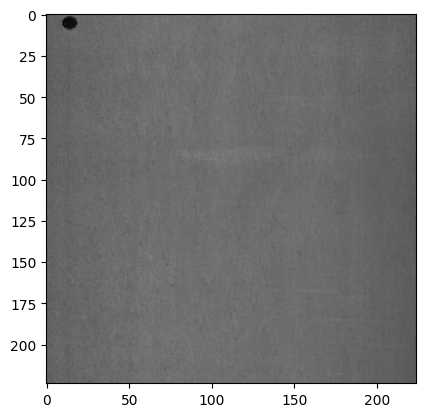

In [16]:
plt.imshow(x_train[0])

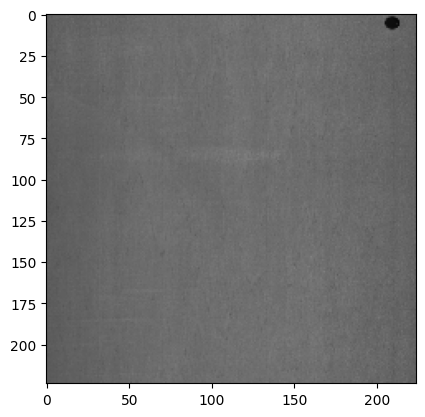

In [17]:

plt.imshow(data_aug_lr(x_train[0]))

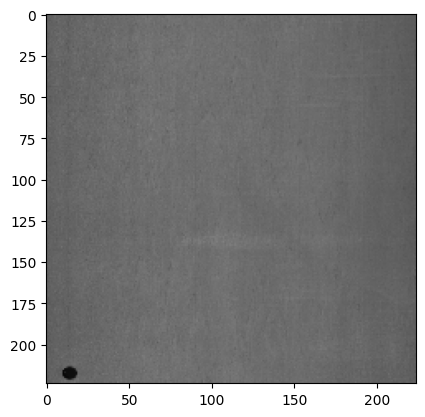

In [18]:
plt.imshow(data_aug_ud(x_train[0]))

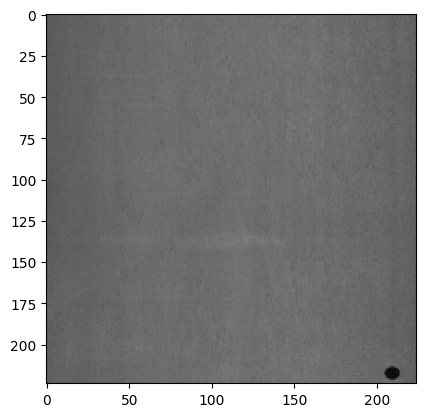

In [19]:
plt.imshow(data_aug_lr_ud(x_train[0]))

In [20]:
"""
a = data_aug_lr(x_train[0])
b = data_aug_ud(x_train[0])
c = data_aug_lr_ud(x_train[0])
d = np.stack((a,b,c))


x_aug = np.copy(d)


for i in x_train:
    a = data_aug_lr(i)
    b = data_aug_ud(i)
    c = data_aug_lr_ud(i)
    d = np.stack((a,b,c))
    x_aug = np.vstack((x_aug,d))
    
    
x_aug.shape
"""

'\na = data_aug_lr(x_train[0])\nb = data_aug_ud(x_train[0])\nc = data_aug_lr_ud(x_train[0])\nd = np.stack((a,b,c))\n\n\nx_aug = np.copy(d)\n\n\nfor i in x_train:\n    a = data_aug_lr(i)\n    b = data_aug_ud(i)\n    c = data_aug_lr_ud(i)\n    d = np.stack((a,b,c))\n    x_aug = np.vstack((x_aug,d))\n    \n    \nx_aug.shape\n'

In [21]:

#x_aug = x_aug[3:] #three first rows was built to code work


In [22]:
"""
y_aug = np.copy(y_train[0])

for j in y_train:
    v = np.copy(y_train[j])
    s = np.vstack((v,v,v))
    y_aug = np.vstack((y_aug,s))
"""

'\ny_aug = np.copy(y_train[0])\n\nfor j in y_train:\n    v = np.copy(y_train[j])\n    s = np.vstack((v,v,v))\n    y_aug = np.vstack((y_aug,s))\n'

In [23]:
#y_aug = y_aug[1:] #three first rows was built to code work


In [24]:
#y_aug.shape

# Model

In [25]:
#Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4)

In [26]:
ResNet = tf.keras.applications.ResNet50V2(input_shape = (224, 224, 3), include_top=False, weights = "imagenet")
ResNet.trainable = False 

In [27]:
model = models.Sequential([
    ResNet,
    layers.GlobalMaxPooling2D(),
    layers.Dense(512, activation='relu'),
    
    layers.Dropout(0.5),
   
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

In [28]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [29]:
history = model.fit(x_train, y_train, epochs=40, validation_data = (x_val, y_val), callbacks = callback)

Epoch 1/40
50/50 [==============================] - 10s 97ms/step - loss: 3.0208 - accuracy: 0.5388 - val_loss: 0.8190 - val_accuracy: 0.7193
Epoch 2/40
50/50 [==============================] - 4s 73ms/step - loss: 0.8801 - accuracy: 0.7312 - val_loss: 0.7043 - val_accuracy: 0.7602
Epoch 3/40
50/50 [==============================] - 4s 72ms/step - loss: 0.7229 - accuracy: 0.7638 - val_loss: 0.8073 - val_accuracy: 0.7719
Epoch 4/40
50/50 [==============================] - 4s 72ms/step - loss: 0.5321 - accuracy: 0.8214 - val_loss: 0.6136 - val_accuracy: 0.8246
Epoch 5/40
50/50 [==============================] - 4s 75ms/step - loss: 0.4224 - accuracy: 0.8490 - val_loss: 0.6072 - val_accuracy: 0.7953
Epoch 6/40
50/50 [==============================] - 4s 74ms/step - loss: 0.3915 - accuracy: 0.8615 - val_loss: 0.5197 - val_accuracy: 0.8216
Epoch 7/40
50/50 [==============================] - 4s 75ms/step - loss: 0.3252 - accuracy: 0.8784 - val_loss: 0.5509 - val_accuracy: 0.8363
Epoch 8/40
5

In [30]:
loss, accuracy = model.evaluate(x_test, y_test)

11/11 [==============================] - 1s 57ms/step - loss: 0.6402 - accuracy: 0.8129


In [31]:
accuracy

0.8128654956817627

In [32]:
loss

0.6402226090431213

In [33]:
predictions = model.predict(x_test)

11/11 [==============================] - 1s 55ms/step


In [34]:
predictions.shape

(342, 10)

In [35]:
y_pred = np.array([])
for i in predictions:
    max_for_each_image = np.array(np.array(i).argmax()) #position of max value; predicted y
    y_pred = np.append(y_pred, max_for_each_image)
y_pred[0]

6.0

In [36]:
cm = confusion_matrix(y_test, y_pred)

In [37]:
cm


array([[ 3,  0,  0,  1,  0,  0,  1,  0,  1,  1],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  5],
       [ 0,  0, 20,  2,  1,  0,  5,  0,  4,  0],
       [ 0,  0,  2, 24,  0,  0,  2,  0,  0,  3],
       [ 0,  0,  0,  0, 23,  0,  1,  0,  0,  9],
       [ 1,  0,  0,  0,  1,  1,  0,  0,  0,  1],
       [ 0,  0,  1,  0,  0,  0, 96,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  5, 14,  1,  1],
       [ 0,  0,  2,  0,  0,  1,  1,  0, 39,  0],
       [ 0,  3,  0,  0,  4,  0,  1,  1,  1, 30]], dtype=int64)

In [38]:
#multilabel_confusion_matrix(y_test, y_pred)

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm)

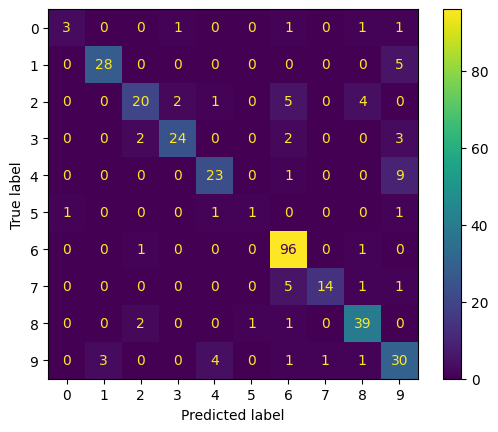

In [40]:
disp.plot()

In [41]:
disp_normalized = ConfusionMatrixDisplay(confusion_matrix = np.round(cm/np.sum(cm, axis = 1).reshape(-1, 1), 2))

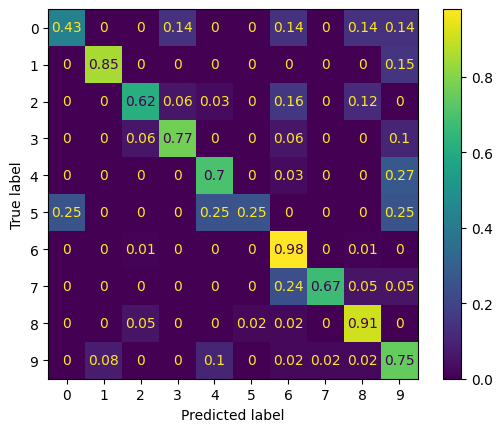

In [42]:
disp_normalized.plot()